Preprocessing complete. Saved: X_train.npy, X_test.npy, y_train.npy, y_test.npy, preprocessor.pkl
                          count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   763.0  121.686763   30.535641  44.000  99.00000   
BloodPressure             733.0   72.405184   12.382158  24.000  64.00000   
SkinThickness             541.0   29.153420   10.476982   7.000  22.00000   
Insulin                   394.0  155.548223  118.775855  14.000  76.25000   
BMI                       757.0   32.457464    6.924988  18.200  27.50000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose            

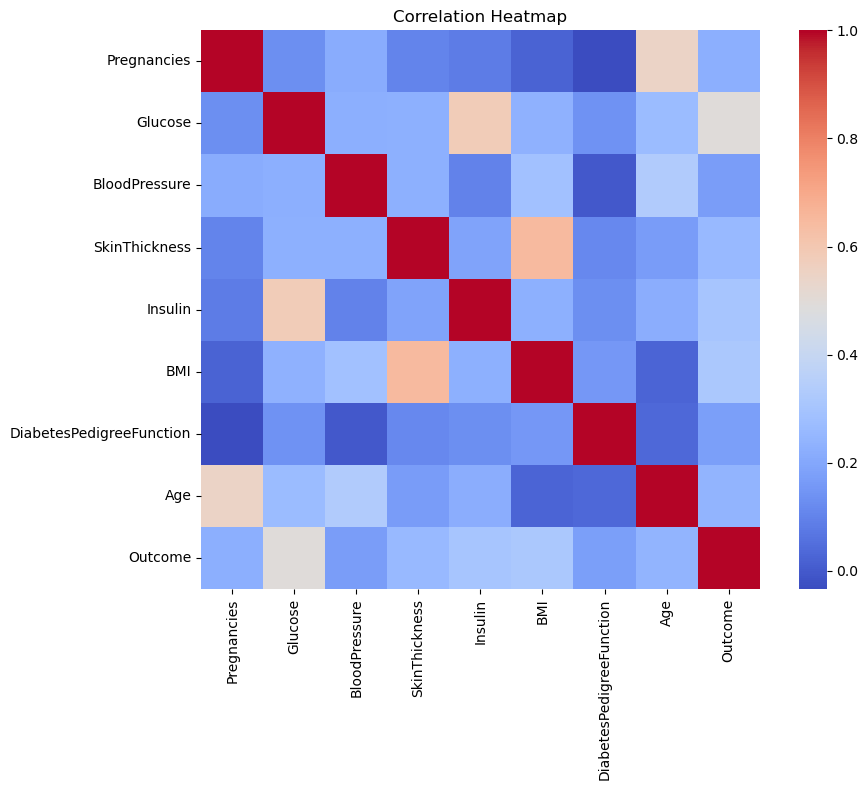

In [2]:
import os, glob, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

CSV_PATH = r"C:\Users\USER\OneDrive\Desktop\Developers Hub\Task1\Dataset\diabetes.csv"
TARGET_COL = "Outcome"
ZERO_AS_MISSING_COLS = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
TEST_SIZE = 0.2
RANDOM_STATE = 42
SKEW_THRESHOLD = 1.0

df = pd.read_csv(CSV_PATH)

for col in ZERO_AS_MISSING_COLS:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

strata = y if y.nunique() <= 20 else None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=strata)

train_skew = X_train[num_cols].skew(numeric_only=True).abs() if num_cols else pd.Series(dtype=float)
median_cols = train_skew[train_skew >= SKEW_THRESHOLD].index.tolist()
mean_cols = [c for c in num_cols if c not in median_cols]

numeric_mean = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler())
])
numeric_median = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])
categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

transformers = []
if mean_cols: transformers.append(("num_mean", numeric_mean, mean_cols))
if median_cols: transformers.append(("num_median", numeric_median, median_cols))
if cat_cols: transformers.append(("cat", categorical, cat_cols))

preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")
preprocessor.fit(X_train)

X_train_t = preprocessor.transform(X_train)
X_test_t  = preprocessor.transform(X_test)

np.save("X_train.npy", X_train_t)
np.save("X_test.npy",  X_test_t)
np.save("y_train.npy", y_train.to_numpy())
np.save("y_test.npy",  y_test.to_numpy())
joblib.dump(preprocessor, "preprocessor.pkl")

print("Preprocessing complete. Saved: X_train.npy, X_test.npy, y_train.npy, y_test.npy, preprocessor.pkl")

print(df.describe().transpose().head(20))

import matplotlib.pyplot as plt
import seaborn as sns

num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] >= 2:
    corr = num_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=False, cmap="coolwarm", square=True)
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for correlation heatmap.")


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib

X_train = np.load("X_train.npy")
X_test  = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test  = np.load("y_test.npy")

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_acc = accuracy_score(y_test, lr.predict(X_test))

rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_acc = accuracy_score(y_test, rf.predict(X_test))

print(f"Logistic Regression Accuracy: {lr_acc:.4f}")
print(f"Random Forest Accuracy: {rf_acc:.4f}")

best_model = rf if rf_acc >= lr_acc else lr
best_name  = "Random Forest" if rf_acc >= lr_acc else "Logistic Regression"
print(f"Best model: {best_name}")

joblib.dump(best_model, "best_model.pkl")
print("Saved best_model.pkl")
